In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


Загрузка данных

In [ ]:
orders = pd.read_excel("orders.xlsx")
products = pd.read_excel("products.xlsx")

Самая ходовая товарная группа

/var/folders/47/sm74yjf52lv9rrhr76bs1n900000gn/T/ipykernel_63080/3423735354.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="quantity", y="level1", palette="viridis")


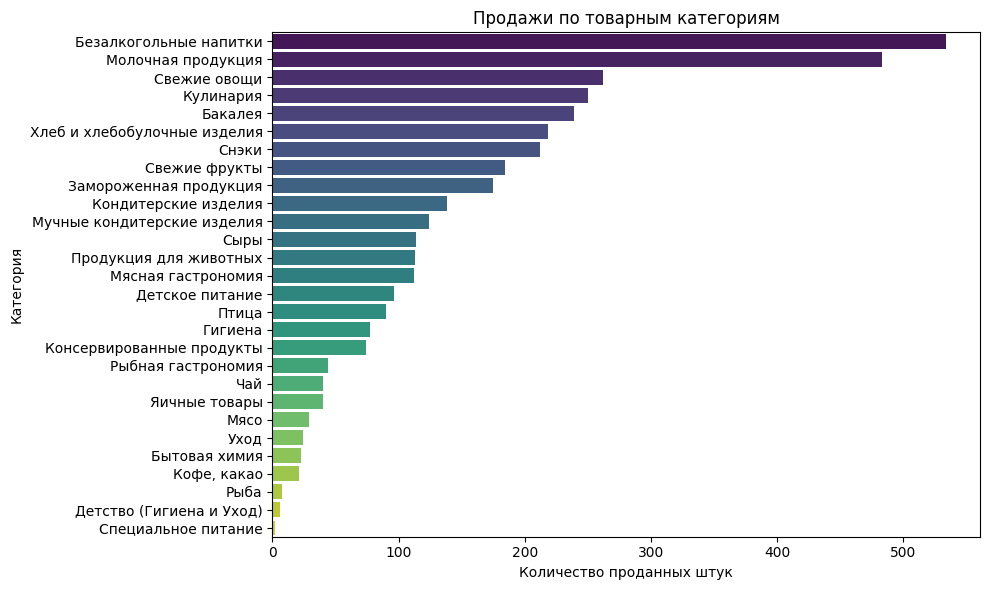

In [ ]:
merged = orders.merge(products, on="product_id", how="inner")

df = merged.groupby("level1")["quantity"].sum().reset_index().sort_values(by="quantity", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="quantity", y="level1", palette="viridis")

plt.title("Продажи по товарным категориям")
plt.xlabel("Количество проданных штук")
plt.ylabel("Категория")
plt.tight_layout()
plt.show()

Распределение продаж по подкатегориям

In [ ]:
df_2 = merged.groupby(["level1", "level2"])["quantity"].sum().reset_index().sort_values('quantity', ascending=False)

print(df_2)


                          level1                        level2  quantity
13        Безалкогольные напитки                       Напитки       252
54                     Кулинария                 Готовые блюда       248
95  Хлеб и хлебобулочные изделия  Хлеб и хлебобулочные изделия       218
86                         Снэки                 Снэки соленые       180
12        Безалкогольные напитки                 Воды питьевые       162
..                           ...                           ...       ...
39          Кондитерские изделия            Пасты кондитерские         2
68            Мясная гастрономия        Субпродуктовые изделия         2
50                   Кофе, какао        Какао, горячий шоколад         2
17                 Бытовая химия       Средства для сантехники         1
85                         Снэки                 Снэки сладкие         1

[100 rows x 3 columns]


Средний чек за 13.01.2022

In [49]:
average_check = (
    orders[orders['accepted_at'].dt.strftime('%Y-%m-%d') == '2022-01-13']
    .groupby('order_id').apply(lambda x: (x['price'] * x['quantity']).sum(), include_groups=False).mean()
)
print(average_check)


915.6378676470588


Доля промо в заданной категории

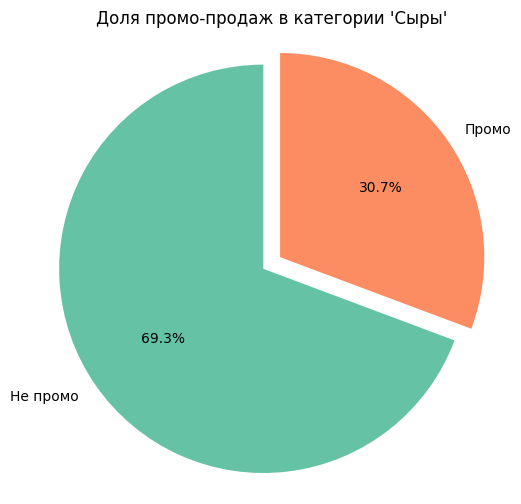

In [54]:
cheese = merged[merged["level1"] == "Сыры"]
values = cheese.groupby(cheese["price"] != cheese["regular_price"])["quantity"].sum().tolist()

labels = ["Не промо", "Промо"]

plt.figure(figsize=(6, 6))
plt.pie(
    values,
    labels=labels,
    autopct="%.1f%%",
    startangle=90,
    colors=["#66c2a5", "#fc8d62"],
    explode = [0.1, 0]
)
plt.title("Доля промо-продаж в категории 'Сыры'")
plt.axis("equal") 
plt.show()

Маржа по категориям

/var/folders/47/sm74yjf52lv9rrhr76bs1n900000gn/T/ipykernel_63080/131078473.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped.sort_values("margin", ascending=False),


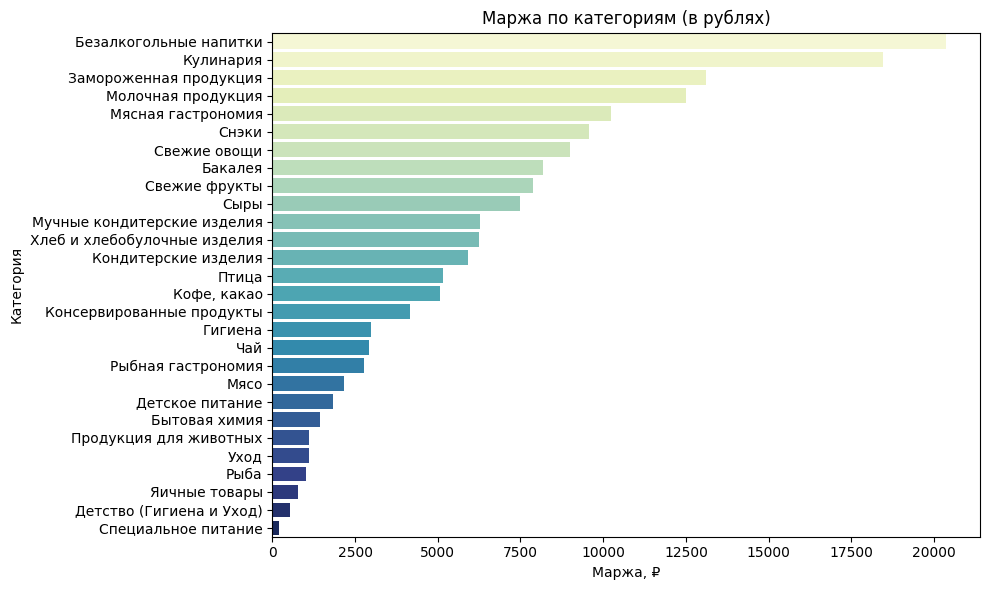

/var/folders/47/sm74yjf52lv9rrhr76bs1n900000gn/T/ipykernel_63080/131078473.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped.sort_values("margin_percent", ascending=False),


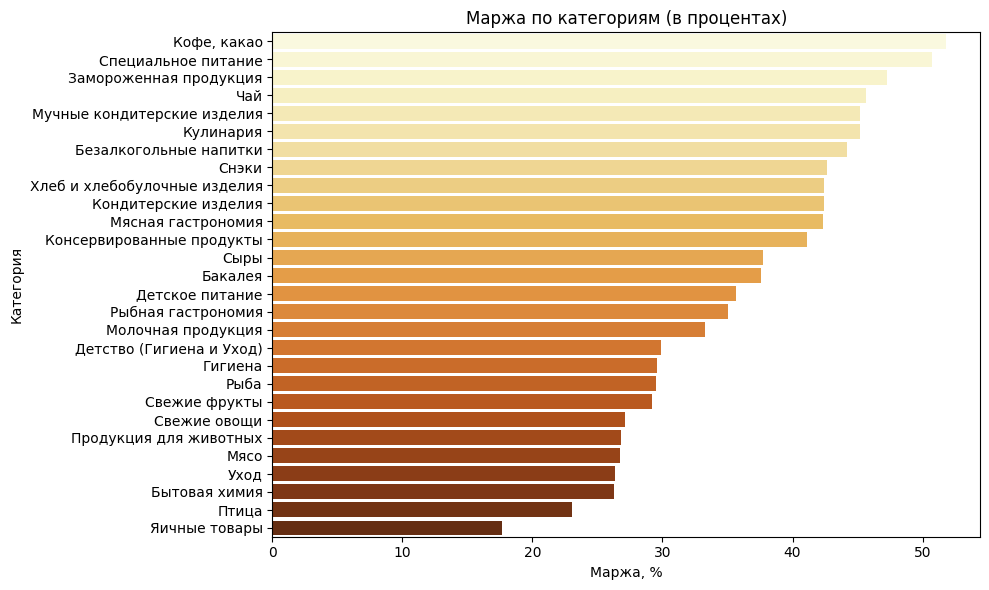

In [56]:
grouped = (
    merged.assign(
        revenue=lambda df: df["price"] * df["quantity"],
        costs=lambda df: df["cost_price"] * df["quantity"],
        margin=lambda df: (df["price"] - df["cost_price"]) * df["quantity"]
    )
    .groupby("level1", as_index=False)
    .agg({"revenue": "sum", "costs": "sum", "margin": "sum"})
    .assign(margin_percent=lambda df: (df["margin"] / df["revenue"]) * 100)
)

# График маржи в рублях
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped.sort_values("margin", ascending=False), 
            x="margin", y="level1", palette="YlGnBu")
plt.title("Маржа по категориям (в рублях)")
plt.xlabel("Маржа, ₽")
plt.ylabel("Категория")
plt.tight_layout()
plt.show()

# График маржи в процентах
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped.sort_values("margin_percent", ascending=False), 
            x="margin_percent", y="level1", palette="YlOrBr")
plt.title("Маржа по категориям (в процентах)")
plt.xlabel("Маржа, %")
plt.ylabel("Категория")
plt.tight_layout()
plt.show()



ABC анализ

In [57]:
def abc_class(cumval):
    return "A" if cumval <= 0.8 else "B" if cumval <= 0.95 else "C"

abc_df = (
    merged.groupby("level2", as_index=False)
    .agg(quantity=("quantity", "sum"), revenue=("revenue", "sum"))
    .assign(
        q_share=lambda df: df["quantity"] / df["quantity"].sum(),
        r_share=lambda df: df["revenue"] / df["revenue"].sum()
    )
    .sort_values("quantity", ascending=False)
    .assign(
        q_cumsum=lambda df: df["q_share"].cumsum(),
        abc_quantity=lambda df: df["q_cumsum"].apply(abc_class)
    )
    .sort_values("revenue", ascending=False)
    .assign(
        r_cumsum=lambda df: df["r_share"].cumsum(),
        abc_revenue=lambda df: df["r_cumsum"].apply(abc_class)
    )
)

abc_df["ABC_group"] = abc_df["abc_quantity"] + " " + abc_df["abc_revenue"]


print(abc_df)

                      level2  quantity  revenue   q_share   r_share  q_cumsum  \
10             Готовые блюда       248    40356  0.066452  0.090322  0.133976   
51                   Напитки       252    24123  0.067524  0.053990  0.067524   
50    Мясо птицы охлажденное        90    22349  0.024116  0.050020  0.534030   
85    Тепличные овощи, грибы       105    18329  0.028135  0.041023  0.482047   
72             Снэки соленые       180    17293  0.048232  0.038704  0.240622   
..                       ...       ...      ...       ...       ...       ...   
77   Средства для сантехники         1      239  0.000268  0.000535  0.999732   
24    Какао, горячий шоколад         2      238  0.000536  0.000533  0.997320   
91  Уход за одеждой и обувью         3      235  0.000804  0.000526  0.988746   
57             Первая помощь         2      168  0.000536  0.000376  0.996785   
71             Снэки сладкие         1       75  0.000268  0.000168  1.000000   

   abc_quantity  r_cumsum a